# HW3_Wet


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.compose import ColumnTransformer



## data preparation

In [47]:
class df_preparation:
    def __init__(self, training_df, df):
        self.training_df = training_df
        self.df = df

    def change_numeric_features(self):
        def change_blood_type():
            self.df['A'] = self.df["blood_type"].isin(["A+", "A-"]).apply(lambda x: int(x))
            self.df['A'] = self.df["blood_type"].isin(["A+", "A-"]).apply(lambda x: int(x))
            self.df['B'] = self.df["blood_type"].isin(["B+", "B-", "AB+", "AB-"]).apply(lambda x: int(x))
            self.df['O'] = self.df["blood_type"].isin(["O+", "O-"]).apply(lambda x: int(x))
            self.df.drop('blood_type', axis=1, inplace=True)

        def change_current_location():
            self.df["current_location_x"] = self.df["current_location"].apply(lambda x: (x.split(","))[0][2:-1]).astype(
                float)
            self.df["current_location_y"] = self.df["current_location"].apply(lambda x: (x.split(","))[1][2:-2]).astype(
                float)
            self.training_df["current_location_x"] = self.training_df["current_location"].apply(lambda x: (x.split(","))[0][2:-1]).astype(
                float)
            self.training_df["current_location_y"] = self.training_df["current_location"].apply(lambda x: (x.split(","))[1][2:-2]).astype(
                float)
            self.df.drop('current_location', axis=1, inplace=True)

        change_current_location()
        change_blood_type()

    def change_categorical_features(self):
        def change_symptoms():
            self.df["low_appetite"] = self.df["symptoms"].str.contains("low_appetite").fillna(value=False).apply(
                lambda x: int(x))
            self.df["cough"] = self.df["symptoms"].str.contains("cough").fillna(value=False).apply(lambda x: int(x))
            self.df["shortness_of_breath"] = self.df["symptoms"].str.contains("shortness_of_breath").fillna(
                value=False).apply(lambda x: int(x))
            self.df["fever"] = self.df["symptoms"].str.contains("fever").fillna(value=False).apply(lambda x: int(x))
            self.df["sore_throat"] = self.df["symptoms"].str.contains("sore_throat").fillna(value=False).apply(
                lambda x: int(x))
            self.df.drop('symptoms', axis=1, inplace=True)

        change_symptoms()

    def drop_features(self):
        self.df.drop(['pcr_date', 'sex', 'patient_id'], axis=1, inplace=True)

    def normalization(self):
        def stdNormal(feature):
            df = self.df[[feature]]
            scaler = StandardScaler()
            scaler.fit(self.training_df[[feature]])  # scaling on training!
            normalaized_feature = scaler.transform(df)
            self.df[feature] = normalaized_feature

        def minMaxNormal(feature):
            df = self.df[[feature]]
            scaler = MinMaxScaler((-1, 1))
            scaler.fit(self.training_df[[feature]])  # scaling on training!
            normalaized_feature = scaler.transform(df)
            self.df[feature] = normalaized_feature

        min_max_features = ['age', 'PCR_03', 'PCR_04', 'PCR_05', 'happiness_score', 'conversations_per_day',
                            'sport_activity', 'PCR_01', 'PCR_02', 'PCR_07', 'PCR_09', 'current_location_y','num_of_siblings']
        std_features = ['weight', 'sugar_levels', 'household_income', 'PCR_06', 'PCR_08', 'PCR_10',
                        'current_location_x']

        for feature in std_features:
            stdNormal(feature)

        for feature in min_max_features:
            minMaxNormal(feature)


def prepare_data(training_df, new_data):
    new_data_return = df_preparation(training_df.copy(), new_data.copy())
    new_data_return.change_categorical_features()
    new_data_return.change_numeric_features()
    new_data_return.drop_features()
    new_data_return.normalization()

    return new_data_return.df

## Updated data loading

In [48]:
df = pd.read_csv('HW3_data.csv')


In [49]:
raw_training_df, raw_test_df = train_test_split(df , random_state = 72)



In [50]:
training_df = prepare_data(raw_training_df, raw_training_df)
test_df =  prepare_data(raw_test_df, raw_training_df)

In [51]:
# X - Normalized vec with all features.
# y - vec wil contamination_level columns
X = training_df.drop(['contamination_level'], axis=1)
y = training_df['contamination_level']
# Normalized training set split into train/validation (20% of training data for validation)
X_subset,X_val, y_subset,y_val = train_test_split(X , y, test_size=0.2,random_state = 72 )



 ### Section 1 ###
 Q(1) in report

In [52]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        n_samples = X.shape[0]
        X = X.to_numpy()
        w = w.reshape(-1, 1)
        y = y.to_numpy().reshape(-1, 1)
        loss = (1.0/n_samples)*np.power(np.linalg.norm((X @ w) + b - y), 2, dtype=np.float64)
        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        n_samples = X.shape[0]
        w_shape = w.shape
        w = w.reshape(-1,1)
        X = X.to_numpy()
        y = y.to_numpy().reshape(-1,1)
        m_1 = np.ones(n_samples).reshape(-1,1)
        g_w = (2.0/n_samples) * (X.T @ ((X @ w) + b - y))
        g_w = g_w.reshape(w_shape)
        g_b = (2.0/n_samples) * float(m_1.T @ ((X @ w) + b - y))

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            assert((self.w).shape == g_w.shape)
            self.w -= self.lr*g_w
            self.b -= self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = (X.dot(self.w.reshape(-1,1))).T + self.b

        return y_pred.T

In [53]:
# copy of verify_gradients.py

def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)
            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

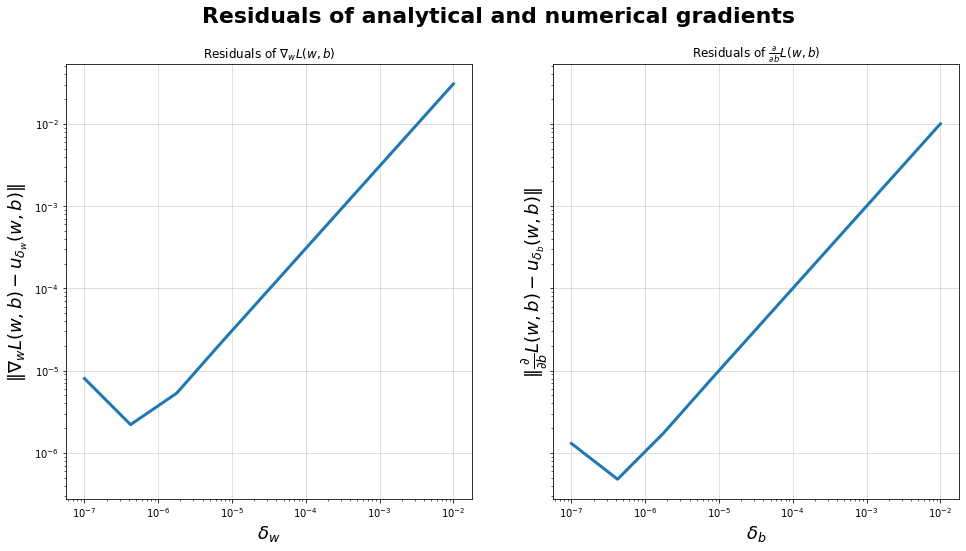

In [54]:
#Q(2)
compare_gradients(X_subset, y_subset, deltas=np.logspace(-7, -2, 9))


In [55]:
#Q(3)

import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 395.39074270334663, Best validation loss = 405.39657136195353
lr size = 1e-08, Best train loss = 395.3406092607302, Best validation loss = 405.3472959536183
lr size = 1e-07, Best train loss = 394.83974818638825, Best validation loss = 404.8550098747134
lr size = 1e-06, Best train loss = 389.87817148541217, Best validation loss = 399.97865153007456
lr size = 1e-05, Best train loss = 344.67861865025264, Best validation loss = 355.5811090361685
lr size = 0.0001, Best train loss = 146.1207906081323, Best validation loss = 161.9549290455517
lr size = 0.001, Best train loss = 95.98746837225114, Best validation loss = 118.24441060150805
lr size = 0.01, Best train loss = 92.62463097807245, Best validation loss = 114.918133796969
lr size = 0.1, Best train loss = 93.605184910526, Best validation loss = 114.73673841291385


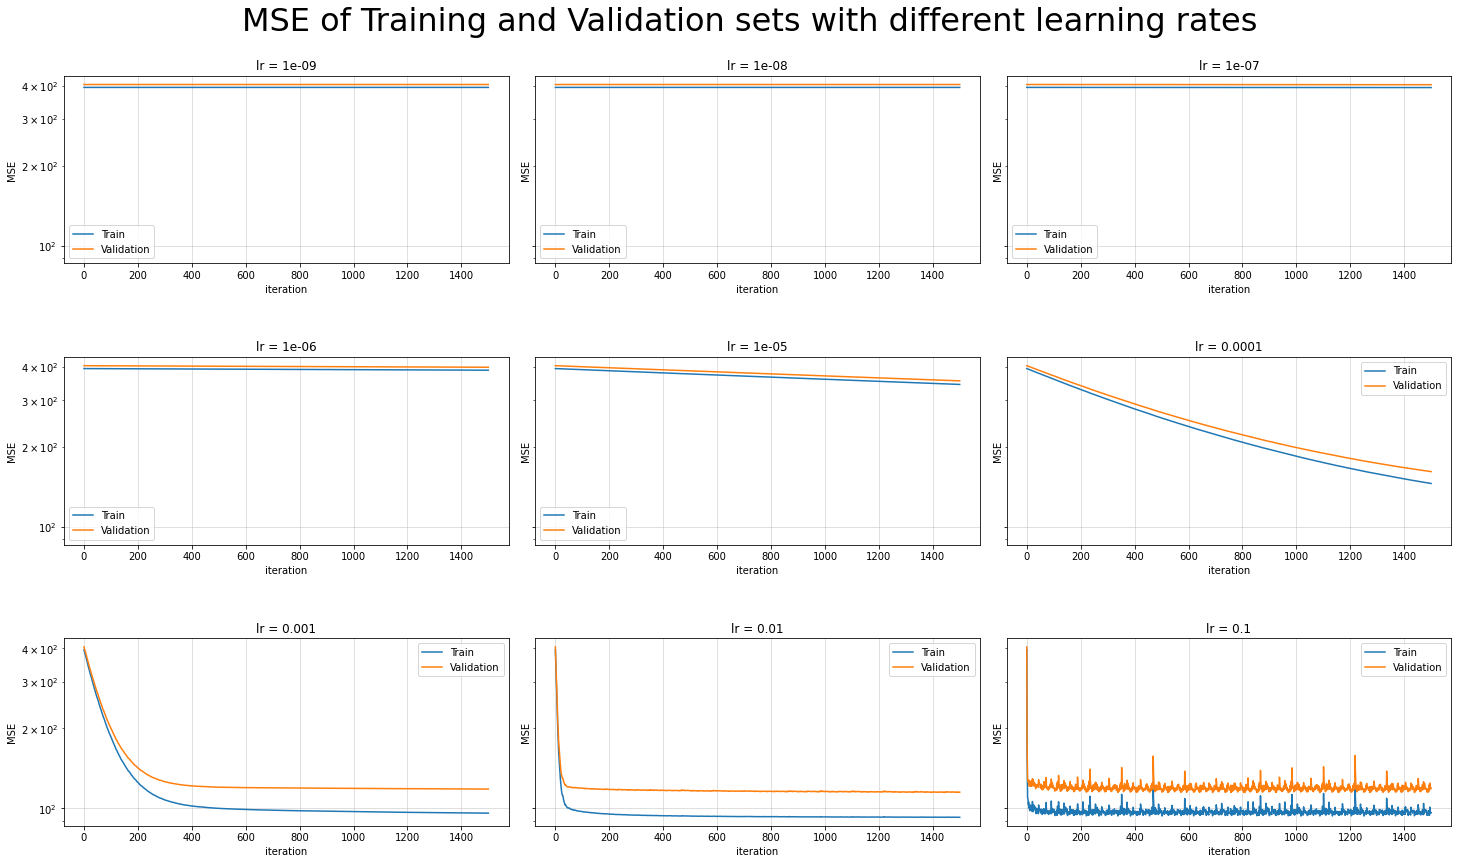

In [56]:
test_lr(X_subset, y_subset, X_val, y_val, title="MSE of Training and Validation sets with different learning rates")

### Section 2: Evaluation and Baseline


In [57]:
#Q(4)
dummy_reg = DummyRegressor(strategy="mean")
scores_dummy = cross_validate(dummy_reg, X, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

print("Mean training loss: {:.2f}".format(np.abs(scores_dummy['train_score'].mean())))
print("Mean validation loss: {:.2f}".format(np.abs(scores_dummy['test_score'].mean())))

Mean training loss: 108.10
Mean validation loss: 108.42


In [58]:
# Save for section 6 - dummy.
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X, y)

DummyRegressor()

In [59]:
lr_vals = np.logspace(-4, -1, 40)
lr_vals_train_mean = []
lr_vals_validation_mean = []

for lr in lr_vals:
    cur_linear_regressor = LinearRegressor(lr)
    scores = cross_validate(cur_linear_regressor, X,  y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
    lr_vals_train_mean.append(np.abs(np.mean(np.array(scores['train_score']))))
    lr_vals_validation_mean.append(np.abs(np.mean(np.array(scores['test_score']))))

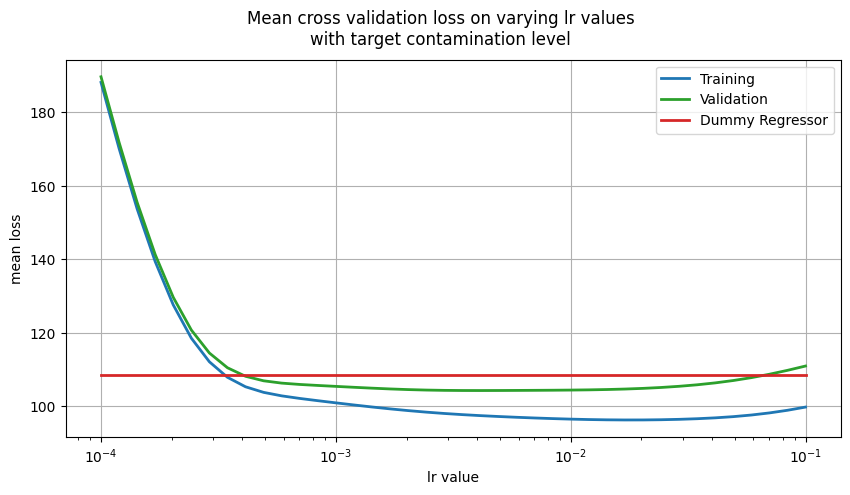

In [60]:
fig, _ = plt.subplots(figsize = (10,5), dpi = 100)
plt.plot(lr_vals, lr_vals_train_mean, lw=2, c='tab:blue', label='Training')
plt.plot(lr_vals, lr_vals_validation_mean, lw=2, c='tab:green', label='Validation')
plt.plot(lr_vals, len(lr_vals)*[np.abs(np.mean(np.array(scores_dummy['test_score'])))], lw=2, c='tab:red', label='Dummy Regressor')
plt.xlabel('lr value')
plt.xscale('log')
plt.ylabel('mean loss')
plt.legend()
plt.grid(visible=True)
plt.suptitle("Mean cross validation loss on varying lr values\nwith target contamination level")
plt.show()



In [61]:
# finding best parameter
opt_lr_index = np.argmin(lr_vals_validation_mean)
opt_lr = lr_vals[opt_lr_index]
print("Optimal lr={}".format(opt_lr))
print("Mean training loss with optimal lr: {:.2f}".format(lr_vals_train_mean[opt_lr_index]))
print("Mean validation loss with optimal lr: {:.2f}".format(lr_vals_validation_mean[opt_lr_index]))


Optimal lr=0.004124626382901352
Mean training loss with optimal lr: 97.39
Mean validation loss with optimal lr: 104.22


In [62]:
# For Section 6 - Opt lr Linear Regressor
linear_reg =LinearRegressor(opt_lr)
linear_reg.fit(X, y)

LinearRegressor(lr=0.004124626382901352)

### Section 3

In [63]:
# Q(7)
alpha_vals = np.logspace(-3, 2, 40)
alpha_vals_train_mean = []
alpha_vals_validation_mean = []

for alpha in alpha_vals:
    lasso_reg = Lasso(alpha=alpha)
    scores = cross_validate(lasso_reg, X, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
    alpha_vals_train_mean.append(np.abs(np.mean(np.array(scores['train_score']))))
    alpha_vals_validation_mean.append(np.abs(np.mean(np.array(scores['test_score']))))


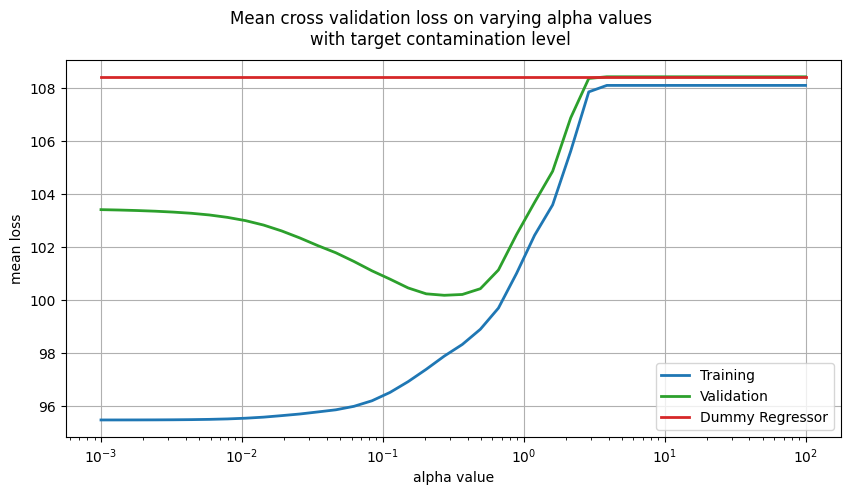

In [64]:
ig, _ = plt.subplots(figsize = (10,5), dpi = 100)
plt.plot(alpha_vals, alpha_vals_train_mean, lw=2, c='tab:blue', label='Training')
plt.plot(alpha_vals, alpha_vals_validation_mean, lw=2, c='tab:green', label='Validation')
plt.plot(alpha_vals, len(alpha_vals)*[np.abs(np.mean(np.array(scores_dummy['test_score'])))], lw=2, c='tab:red', label='Dummy Regressor')
plt.xlabel('alpha value')
plt.xscale('log')
plt.ylabel('mean loss')
plt.legend()
plt.grid(visible=True)
plt.suptitle("Mean cross validation loss on varying alpha values\nwith target contamination level")
plt.show()



In [65]:
# finding best parameter
opt_alpha_index = np.argmin(alpha_vals_validation_mean)
opt_alpha = alpha_vals[opt_alpha_index]
print("Optimal alpha={}".format(opt_alpha))
print("Mean training loss with optimal alpha: {:.2f}".format(alpha_vals_train_mean[opt_alpha_index]))
print("Mean validation loss with optimal alpha: {:.2f}".format(alpha_vals_validation_mean[opt_alpha_index]))


Optimal alpha=0.2728333376486767
Mean training loss with optimal alpha: 97.88
Mean validation loss with optimal alpha: 100.17


In [66]:

lasso_reg = Lasso(alpha=opt_alpha)
lasso_reg.fit(training_df.drop(['contamination_level'], axis=1), training_df['contamination_level'])

Lasso(alpha=0.2728333376486767)

Q(8) - on report

In [67]:
# Q(9)
top_5_coef_indices = list(np.argsort(np.abs(lasso_reg.coef_)))[-5:]
top_5_coef_indices.reverse()
print('Top 5 features and their absolute coefficients:')
print(np.array([training_df.drop(['contamination_level'],axis=1).columns[top_5_coef_indices], np.abs(lasso_reg.coef_)[top_5_coef_indices]]).T)

Top 5 features and their absolute coefficients:
[['sugar_levels' 2.3256087584934084]
 ['PCR_01' 2.1611692695609457]
 ['low_appetite' 0.12283656981561519]
 ['PCR_10' 0.05479358693257271]
 ['current_location_x' 0.045453952014649766]]


[2.32560876 2.16116927 0.12283657 0.05479359 0.04545395 0.03326425
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


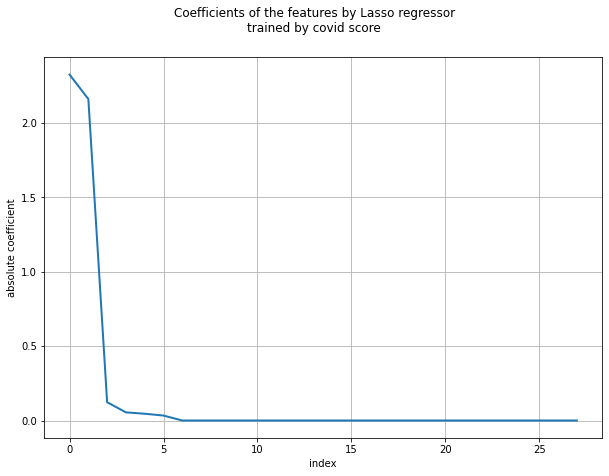

In [68]:
# Q(10)
sorted_abs_coef = np.sort(np.abs(lasso_reg.coef_))[::-1]
print(sorted_abs_coef)
indices = list(range(len(sorted_abs_coef)))
fig, _ = plt.subplots()
fig.set_size_inches(10,7)
plt.plot(indices, sorted_abs_coef, lw=2)
plt.xlabel('index')
plt.ylabel('absolute coefficient')
plt.grid(visible=True)
plt.suptitle("Coefficients of the features by Lasso regressor\ntrained by covid score")

plt.show()

Q(11) and Q(12) on report

### Section 4

In [69]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

In [70]:
# Q13
training = training_df[['PCR_01','PCR_05','contamination_level']]

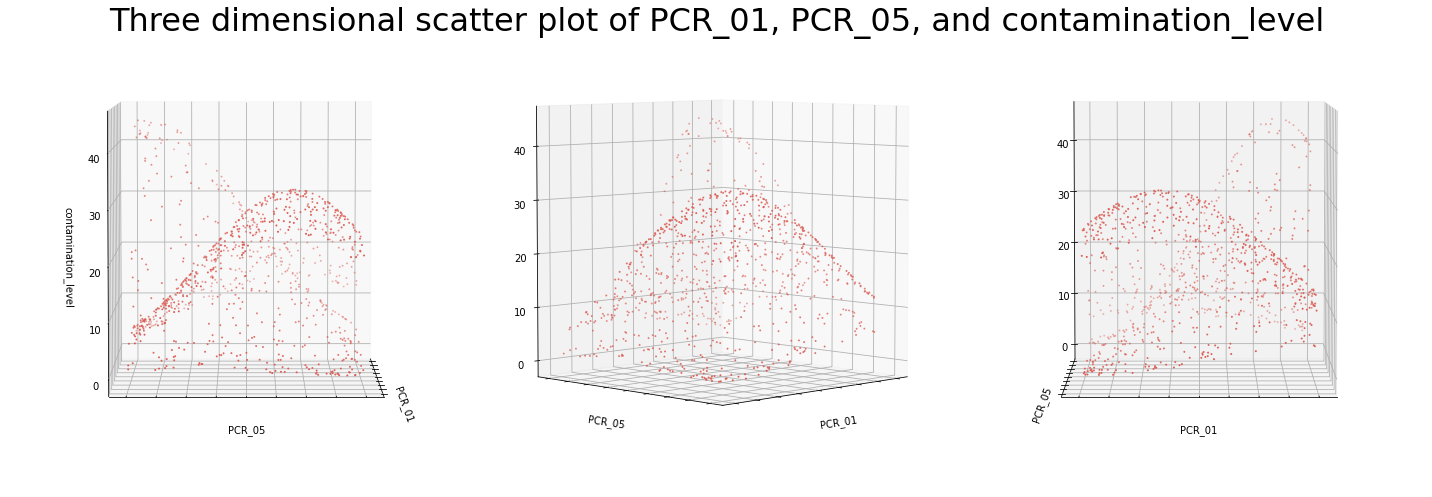

In [71]:
train_subset_features_spread = training[['PCR_01', 'PCR_05']]
train_subset_target_spread = training['contamination_level']
plot3d(training, colX='PCR_01', colY='PCR_05', colZ='contamination_level', title="Three dimensional scatter plot of PCR_01, PCR_05, and contamination_level")

In [72]:
# Q(14)

alpha_vals = np.logspace(-3, 1, 25)
alpha_vals_train_mean = []
alpha_vals_validation_mean = []

for alpha in alpha_vals:
    lasso_reg2 = Lasso(alpha=alpha)
    scores = cross_validate(lasso_reg2, training[['PCR_01','PCR_05']], training['contamination_level'], cv=5, return_train_score=True, scoring='neg_mean_squared_error')
    alpha_vals_train_mean.append(np.abs(np.mean(np.array(scores['train_score']))))
    alpha_vals_validation_mean.append(np.abs(np.mean(np.array(scores['test_score']))))


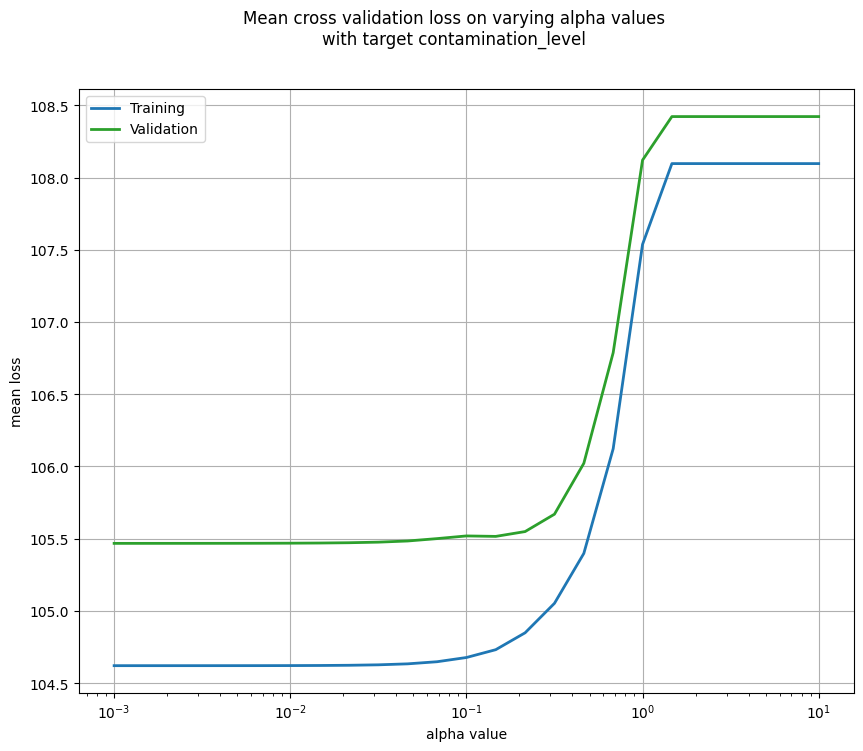

In [73]:
fig, _ = plt.subplots(figsize = (10,5), dpi = 100)
fig.set_size_inches(10,8)
plt.plot(alpha_vals, alpha_vals_train_mean, lw=2, c='tab:blue', label='Training')
plt.plot(alpha_vals, alpha_vals_validation_mean,  lw=2, c='tab:green', label='Validation')
plt.xlabel('alpha value')
plt.xscale('log')
plt.ylabel('mean loss')
plt.legend()
plt.grid(visible=True)
plt.suptitle("Mean cross validation loss on varying alpha values\nwith target contamination_level")
plt.show()



In [74]:
# finding best alpha for spread
opt_alpha_index = np.argmin(alpha_vals_validation_mean)
opt_alpha = alpha_vals[opt_alpha_index]
print("Optimal alpha={}".format(opt_alpha))
print("Mean training loss with optimal alpha: {:.2f}".format(alpha_vals_train_mean[opt_alpha_index]))
print("Mean validation loss with optimal alpha: {:.2f}".format(alpha_vals_validation_mean[opt_alpha_index]))

Optimal alpha=0.001
Mean training loss with optimal alpha: 104.62
Mean validation loss with optimal alpha: 105.47


In [75]:
# retrain on all trainging data - ridge regressor with optimal alpha/lambda
Regressor_q14 = Lasso(alpha=opt_alpha)
Regressor_q14.fit(train_subset_features_spread, train_subset_target_spread)

Lasso(alpha=0.001)

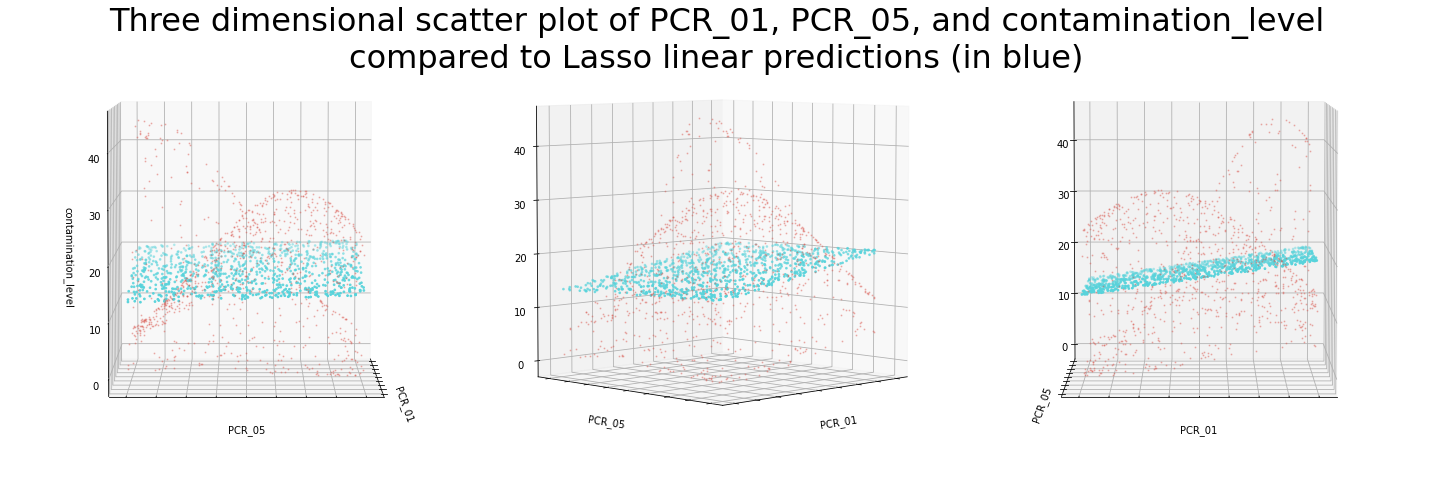

In [76]:
#Q(15)
plot3d(training, colX='PCR_01', colY='PCR_05', colZ='contamination_level', title="Three dimensional scatter plot of PCR_01, PCR_05, and contamination_level\ncompared to Lasso linear predictions (in blue)", 
       predictions=Regressor_q14.predict(train_subset_features_spread))

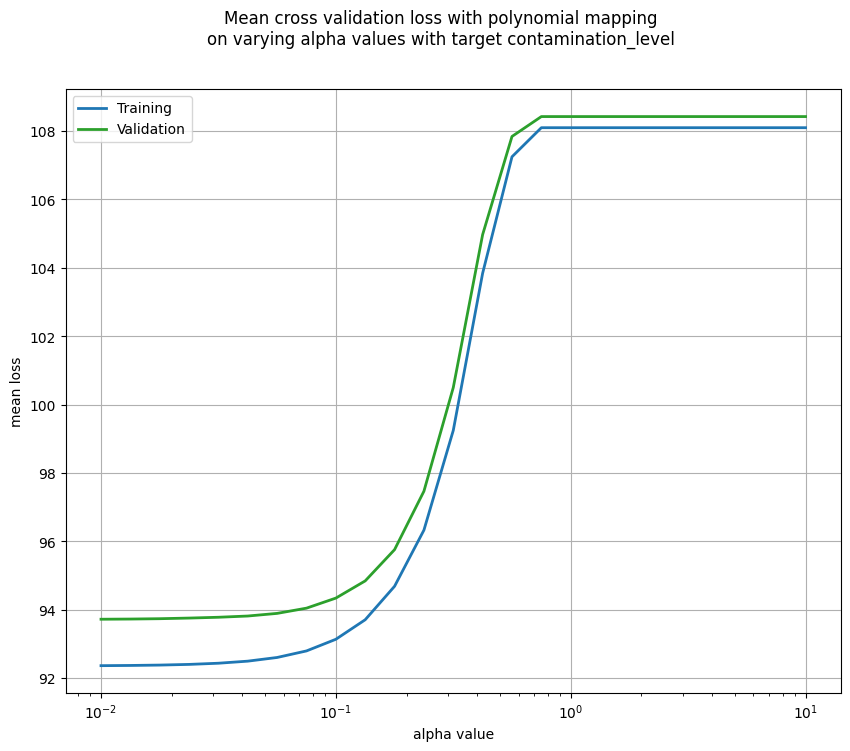

In [77]:
# Q(17)
alpha_vals = np.logspace(-2, 1, 25)
alpha_vals_train_mean = []
alpha_vals_validation_mean = []

for alpha in alpha_vals:
    poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(2)),
                         ('normalization', MinMaxScaler()),
                         ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])
    scores = cross_validate(poly_reg, training[['PCR_01','PCR_05']], training['contamination_level'], cv=5, return_train_score=True, scoring='neg_mean_squared_error')
    alpha_vals_train_mean.append(np.abs(np.mean(np.array(scores['train_score']))))
    alpha_vals_validation_mean.append(np.abs(np.mean(np.array(scores['test_score']))))

fig, _ = plt.subplots(figsize = (10,5), dpi = 100)
fig.set_size_inches(10,8)
plt.plot(alpha_vals, alpha_vals_train_mean, lw=2, c='tab:blue', label='Training')
plt.plot(alpha_vals, alpha_vals_validation_mean, lw=2, c='tab:green', label='Validation')
plt.xlabel('alpha value')
plt.xscale('log')
plt.ylabel('mean loss')
plt.legend()
plt.grid(visible=True)
plt.suptitle("Mean cross validation loss with polynomial mapping\non varying alpha values with target contamination_level")
plt.show()



In [78]:
# finding best alpha/lambda
opt_alpha_index_q17 = np.argmin(alpha_vals_validation_mean)
opt_alpha_q17 = alpha_vals[opt_alpha_index_q17]
print("Optimal alpha={}".format(opt_alpha_q17))
print("Mean training loss with optimal alpha: {:.2f}".format(alpha_vals_train_mean[opt_alpha_index_q17]))
print("Mean validation loss with optimal alpha: {:.2f}".format(alpha_vals_validation_mean[opt_alpha_index_q17]))

Optimal alpha=0.01
Mean training loss with optimal alpha: 92.36
Mean validation loss with optimal alpha: 93.72


In [79]:
Regressor_q17 = Pipeline([('feature_mapping', PolynomialFeatures(2)),
                         ('normalization', MinMaxScaler()),
                         ('Lasso', Lasso(alpha=opt_alpha_q17, fit_intercept=True))])
Regressor_q17.fit(training[['PCR_01','PCR_05']], training['contamination_level'])

Pipeline(steps=[('feature_mapping', PolynomialFeatures()),
                ('normalization', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.01))])

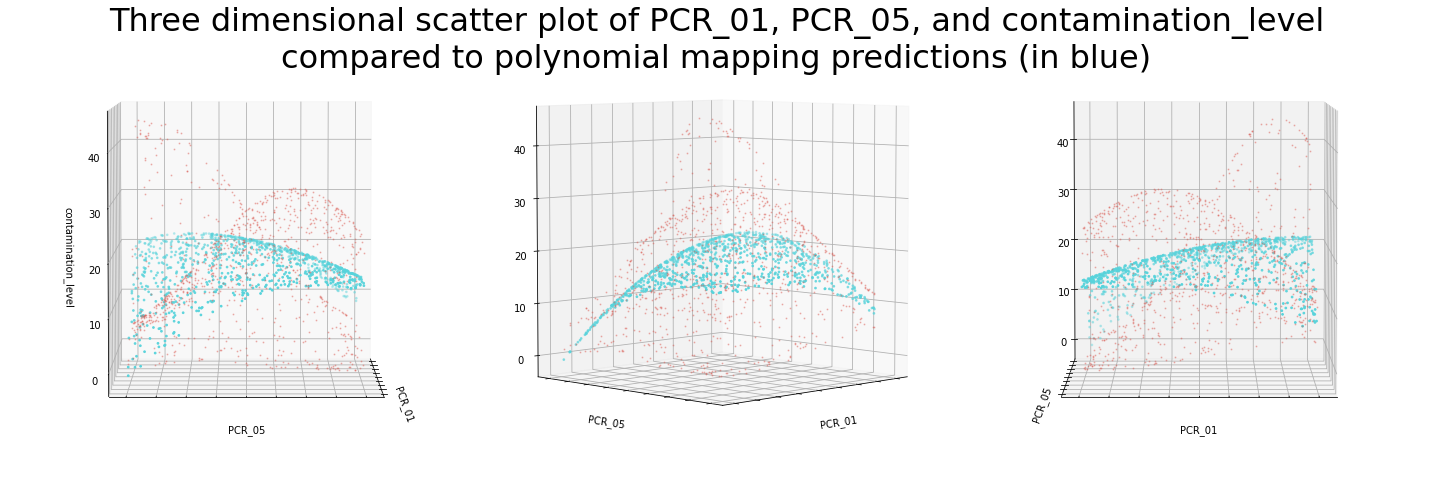

In [80]:
# Q(18)
plot3d(training, colX='PCR_01', colY='PCR_05', colZ='contamination_level',
              title="Three dimensional scatter plot of PCR_01, PCR_05, and contamination_level\ncompared to polynomial mapping predictions (in blue)",
              predictions=Regressor_q17.predict(training[['PCR_01','PCR_05']]))

### Section 5: RandomForest fitting of the CovidScore


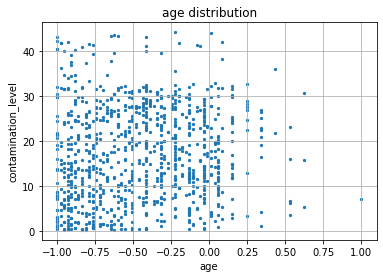

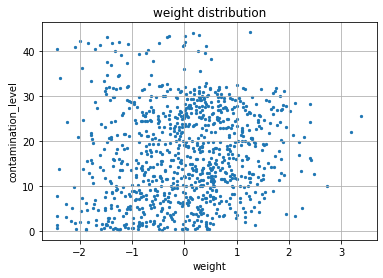

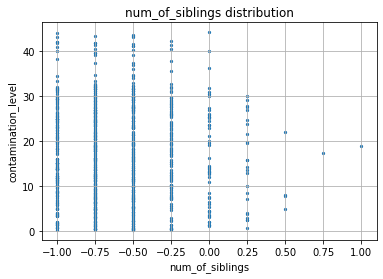

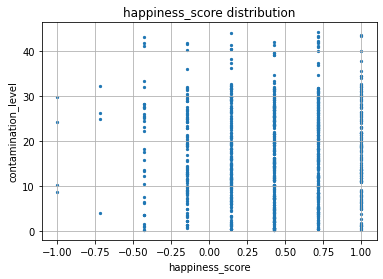

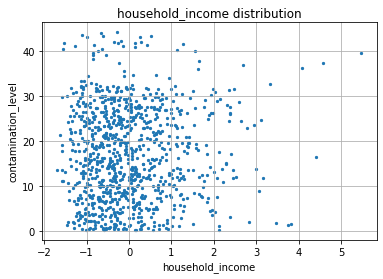

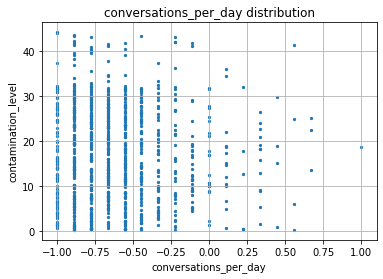

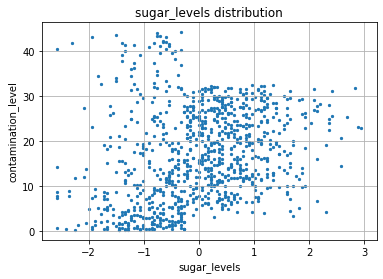

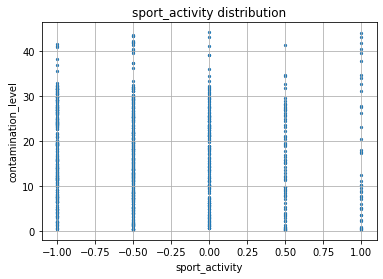

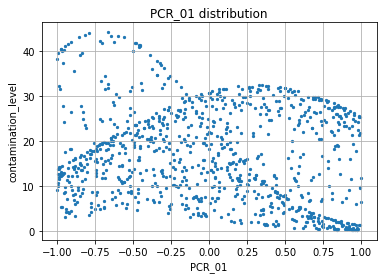

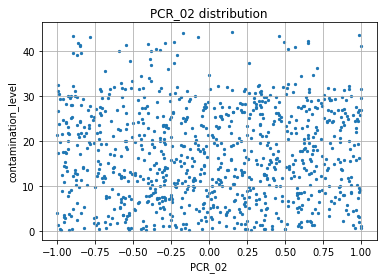

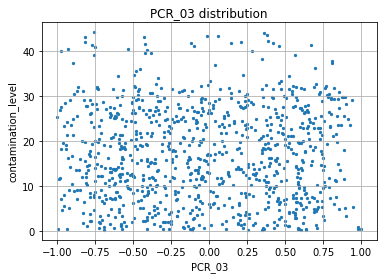

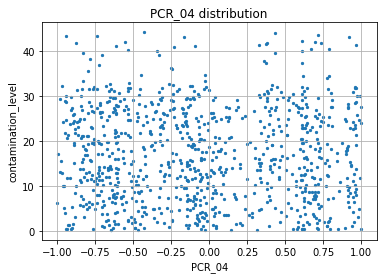

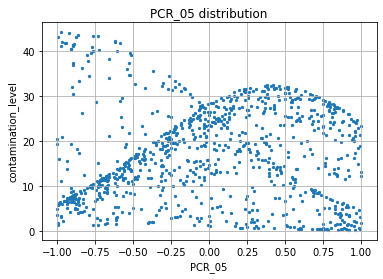

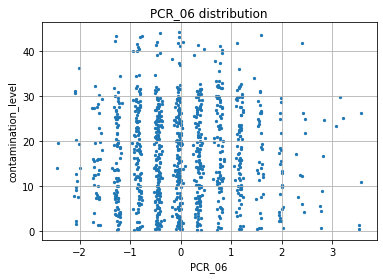

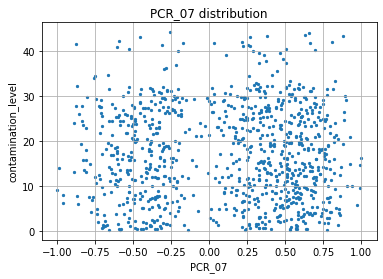

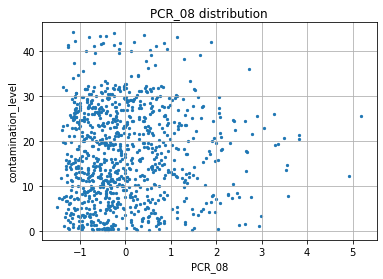

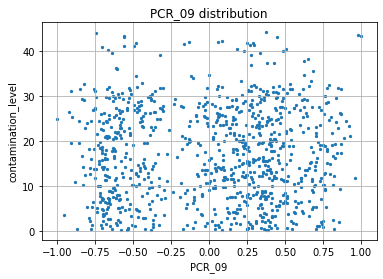

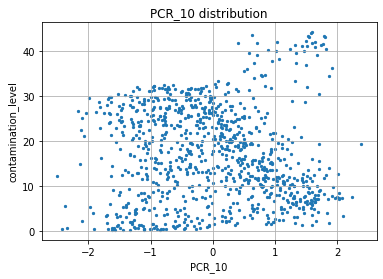

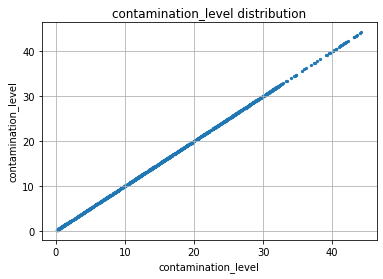

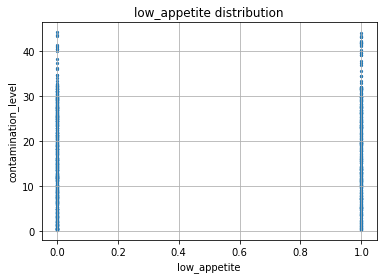

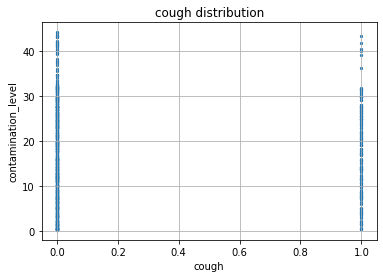

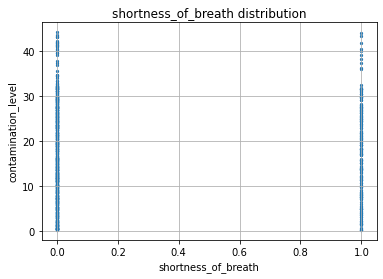

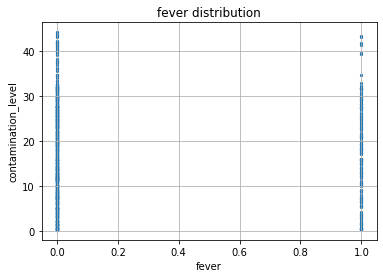

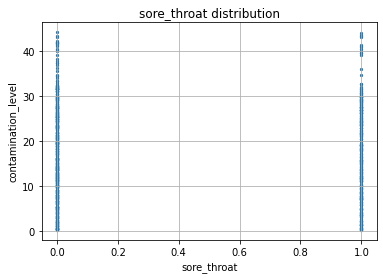

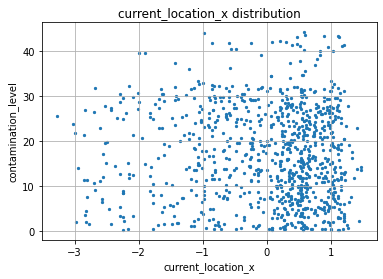

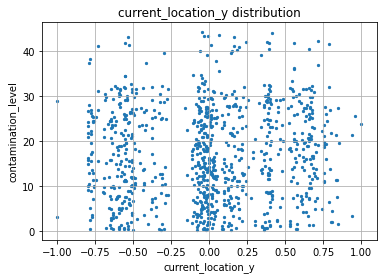

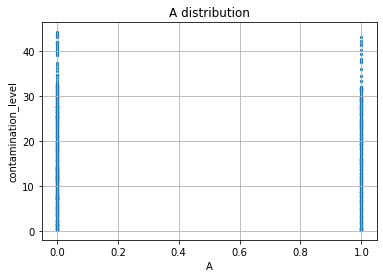

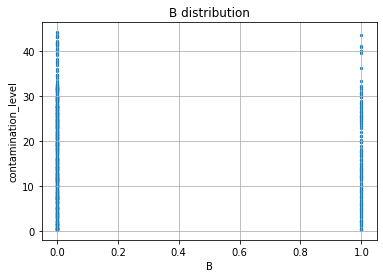

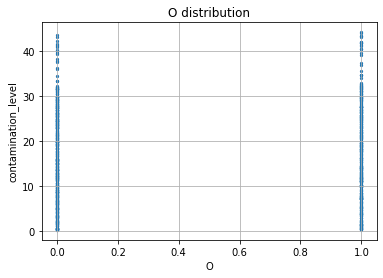

In [81]:
# Q(20)

training_all_feature_copy = training_df.copy()
test_all_feature_copy = test_df.copy()
X_train_copy = training_all_feature_copy.drop(['contamination_level'], axis=1)
y_train_copy = training_all_feature_copy['contamination_level']
X_test_copy = test_all_feature_copy.drop(['contamination_level'], axis=1)
y_test_copy = test_all_feature_copy['contamination_level']

# for j in training_df.columns:
for j in training_df.columns:
  plt.scatter(x= training_all_feature_copy[j] , y= training_all_feature_copy['contamination_level'], s = 5)
  plt.xlabel(j)
  plt.ylabel('contamination_level')
  plt.title(j +' distribution')
  plt.grid()
  plt.show()

In [82]:
import itertools
best_score = 0


features = []
for i in ['sugar_levels','PCR_01','PCR_05','PCR_10','current_location_x']:
    features.append(X_train_copy.columns.get_loc(i))
print(features)

partitions = [
    (list(combination1), list(combination2), [item for item in features if item not in combination1 and item not in combination2])
    for i in range(1, len(features))
    for combination1 in itertools.combinations(features, i)
    for j in range(i+1, len(features))
    for combination2 in itertools.combinations(features, j)
]
for i in partitions:
  rbf_features_attempt = i[0]
  polynomial_features_attempt = i[1]
  no_map_features_attempt = i[2]
  

  for gamma in [0.0001]:
      preprocessor = ColumnTransformer(
      transformers=[
          ('rbf', RBFSampler(random_state=72, gamma = gamma), rbf_features_attempt),
          ('poly', PolynomialFeatures(degree=2), polynomial_features_attempt),
          ('no_map', 'passthrough', no_map_features_attempt)

        ])

      # Define the pipeline
      pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('mapper', preprocessor),
        ('regressor', RandomForestRegressor())
      ])
      param_grid = {
        'regressor__n_estimators': [100], # default features
        'regressor__max_depth': [20],
          }

      # Perform the grid search
      grid = GridSearchCV(pipe, param_grid, cv=5)
      grid.fit(X_train_copy, y_train_copy)

      if grid.best_score_ > best_score:
          best_score = grid.best_score_
          best_rbf = rbf_features_attempt
          best_poly = polynomial_features_attempt
          best_no_map = no_map_features_attempt

print('rbf features : ' + str(best_rbf))
print('poly features : ' + str(best_poly))
print('regular features : ' + str(best_no_map))
print('best score : ' + str(best_score))




[6, 8, 12, 17, 23]
rbf features : [8]
poly features : [8, 12]
regular features : [6, 17, 23]
best score : 0.9910375651158432


In [83]:
corr_features = training_df[['sugar_levels' , 'PCR_01','PCR_05','PCR_10','contamination_level']]
print(corr_features.corr())


                     sugar_levels    PCR_01    PCR_05    PCR_10  \
sugar_levels             1.000000 -0.035951  0.033526 -0.046030   
PCR_01                  -0.035951  1.000000  0.004947 -0.004231   
PCR_05                   0.033526  0.004947  1.000000 -0.926097   
PCR_10                  -0.046030 -0.004231 -0.926097  1.000000   
contamination_level      0.254438 -0.174791  0.032456 -0.041070   

                     contamination_level  
sugar_levels                    0.254438  
PCR_01                         -0.174791  
PCR_05                          0.032456  
PCR_10                         -0.041070  
contamination_level             1.000000  


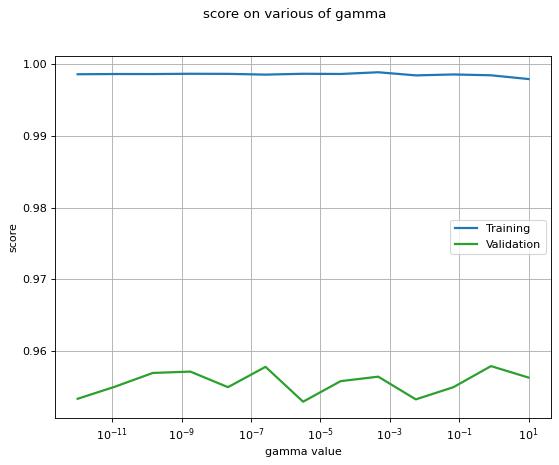

In [154]:

gamma_vals = np.logspace(-12, 1, 13)
gamma_vals_train_mean = []
gamma_vals_validation_mean = []
for gamma in gamma_vals:
  preprocessor = ColumnTransformer(
      transformers=[
          ('rbf', RBFSampler(random_state=72, gamma = gamma), best_rbf),
          ('poly', PolynomialFeatures(degree=2), best_poly),
          ('no_map', 'passthrough', [0,1,2,3,4,5,6,7,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
)
          ])
  pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('mapper', preprocessor),
        ('regressor', RandomForestRegressor())
      ])
  pipe.fit(X_train_copy, y_train_copy)
  scores = pipe.score(X_train_copy, y_train_copy)
  gamma_vals_train_mean.append(np.abs(scores))
  scores = pipe.score(X_test_copy, y_test_copy)
  gamma_vals_validation_mean.append(np.abs(scores))
  
fig, _ = plt.subplots(figsize = (7,4), dpi = 80)
fig.set_size_inches(8,6)
plt.plot(gamma_vals, gamma_vals_train_mean, lw=2, c='tab:blue', label='Training')
plt.plot(gamma_vals, gamma_vals_validation_mean, lw=2, c='tab:green', label='Validation')
plt.xlabel('gamma value')
plt.xscale('log')
plt.ylabel('score')
plt.legend()
plt.grid(visible=True)
plt.suptitle("score on various of gamma")
plt.show()

In [155]:
# Q(23)
rbf_features = [8]
poly_features = [8,12]
no_map_features = [0,1,2,3,4,5,6,7,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
preprocessor = ColumnTransformer(
      transformers=[
          ('rbf', RBFSampler(random_state=72, gamma = 1e-6), best_rbf),
          ('poly', PolynomialFeatures(degree=2), best_poly),
          ('no_map', 'passthrough', no_map_features)
      ])
pipe = Pipeline([
      ('scaler', MinMaxScaler()),
      ('mapper', preprocessor),
      ('regressor', RandomForestRegressor())
    ])

n_estimators = list(range(10, 60, 10))
min_samples_leaf = list(range(1, 10, 1))
parameters = {'regressor__n_estimators':n_estimators, 'regressor__min_samples_leaf': min_samples_leaf}
grid_rf = GridSearchCV(pipe, parameters, return_train_score=True,cv=8 , scoring ='neg_mean_squared_error')

grid_rf.fit(X_train_copy, y_train_copy)

validation_scores = grid_rf.cv_results_['mean_test_score'].reshape(len(n_estimators),len(min_samples_leaf))
training_scores = grid_rf.cv_results_['mean_train_score'].reshape(len(n_estimators),len(min_samples_leaf))


Text(0.5, 1.0, 'Mean validation MSE')

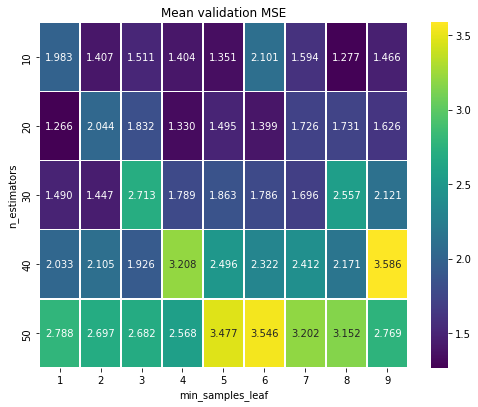

In [179]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
p = sns.heatmap(np.abs(validation_scores), cmap='viridis', annot = True, xticklabels = min_samples_leaf, yticklabels = n_estimators,linewidths=.5, fmt=".3f" )
p.set_xlabel("min_samples_leaf", fontsize = 10)
p.set_ylabel("n_estimators", fontsize = 10)
plt.title('Mean validation MSE')

Text(0.5, 1.0, 'Mean training MSE')

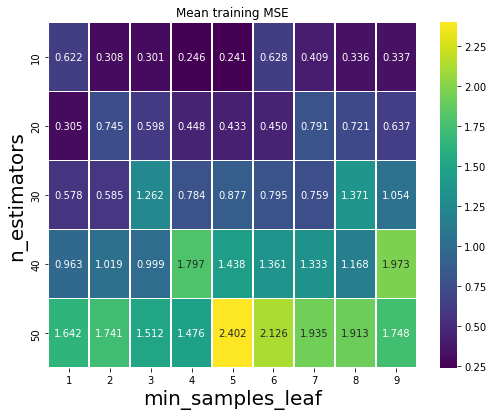

In [180]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
p = sns.heatmap(np.abs(training_scores),cmap="viridis", annot = True, xticklabels = min_samples_leaf, yticklabels = n_estimators,linewidths=.5,fmt=".3f")
p.set_xlabel("min_samples_leaf", fontsize = 20)
p.set_ylabel("n_estimators", fontsize = 20)
plt.title('Mean training MSE')

In [158]:
 # Q(24) on report
 

In [209]:
# Q(25)

preprocessor = ColumnTransformer(
      transformers=[
          ('rbf', RBFSampler(random_state=72, gamma = 1e-6), best_rbf),
          ('poly', PolynomialFeatures(degree=2), best_poly),
          ('no_map', 'passthrough', no_map_features)
      ])
pipe = Pipeline([
      ('scaler', MinMaxScaler()),
      ('mapper', preprocessor),
      ('regressor', RandomForestRegressor(n_estimators = 20 , min_samples_leaf = 1))
    ])
pipe.fit(X_train_copy , y_train_copy)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('mapper',
                 ColumnTransformer(transformers=[('rbf',
                                                  RBFSampler(gamma=1e-06,
                                                             random_state=72),
                                                  [8]),
                                                 ('poly', PolynomialFeatures(),
                                                  [8, 12]),
                                                 ('no_map', 'passthrough',
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 9,
                                                   10, 11, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27])])),
                ('regressor', RandomForestRegressor(n_estimators=20))])

In [210]:
from sklearn.metrics import mean_squared_error

models = [dummy_reg, linear_reg, lasso_reg, pipe]
mse_scores = []

for model in models:
    y_pred = model.predict(X_test_copy)
    mse = mean_squared_error(y_test_copy, y_pred)
    mse_scores.append(mse)

print(mse_scores)

[108.12696900636519, 98.32414526327526, 98.29328552215861, 4.900632681255535]
